## Generating Artificial Flows ##

From the trained hierarchical model, with the given data we can now construct our artifical flow generation function. This function, when called, should yield an artificially obtained latent space, without needing to solve the Navier-Stokes equation, which can then be decoded into a frame of flow data of the same type as the given data.

In commencing, we can first extract all latent spaces from the given frames. In this way, we will obtain four lists, each containing all individual values of a certain mode as obtained from the encoding of the given data set.

In [1]:
import random
import numpy as np
from FlowCompression.FlowGeneration.FlowGeneration import *
import matplotlib.pyplot as plt

# generate a latent space for each frame of the original data set and divide them in modes
mode1, mode2, mode3, mode4 = np.transpose(generation_from_original(u_all))

Now we have all values of all modes, we can conduct some statistical analysis, and scatter plot the values for the first three modes. In this way, the parameter space for these modes, the three most important modes of the latent space, can be visualised. By conducting this statistical analysis, we can model some probability distribution functions, and use these functions to randomly generate a latent space. This can then be fed through the decoder of our model, yielding an artificially generated frame of flow data.

In [2]:
def stats(mode: list[float]):
    """
    Determines statistics of a list of values related to one mode of the latent space
    :param mode: the values of the given mode in all latent spaces of a certain time series
    :return: a tuple of 5 statistics: midpoint, radius, maximum, minimum, average
    """
    mx = np.max(mode)
    mn = np.min(mode)
    return (mx + mn) / 2, (mx - mn) / 2, mx, mn, np.average(mode)


def plot_scatter(mode1: list[float], mode2: list[float], mode3: list[float]):
    """
    Function to create the scatter plot of three different modes
    :param mode1: list of the magnitudes for the first latent space mode
    :param mode2: list of the magnitudes for the first latent space mode
    :param mode3: list of the magnitudes for the first latent space mode
    :return: None, plots figure
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(mode1, mode2, mode3)
    ax.set_xlabel('m1')
    ax.set_ylabel('m2')
    ax.set_zlabel('m3')
    plt.show()

As can be seen, the scatter plot displays a spheroid shape. To parametrise this, a spheroid can be constructed, with the 3 major axes respectively spanning the range of values of the first 3 modes. Furthermore, the relevant polar and azimuthal angles can be computed. Subsequently, we can find the distances of all points from the center of this spheroid, and we can plot the histogram of these distances, as well as the histograms of the polar and azimuthal angles, respectively.

max: 0.47206987724253047
min: -2.1449538805165127
avg: -0.34671896172862365


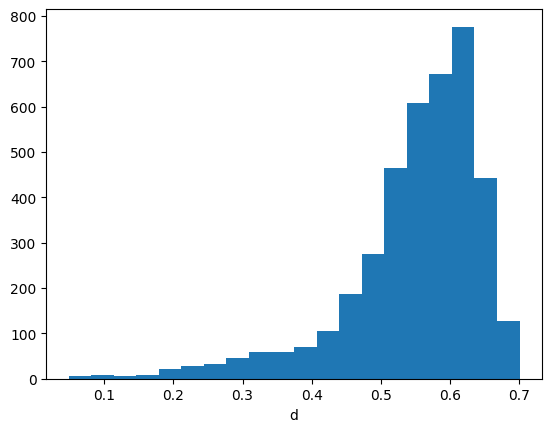

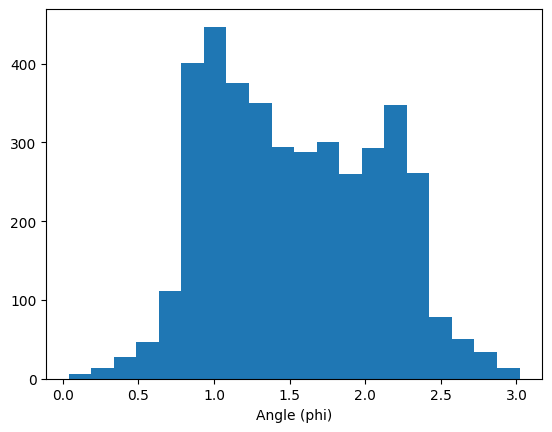

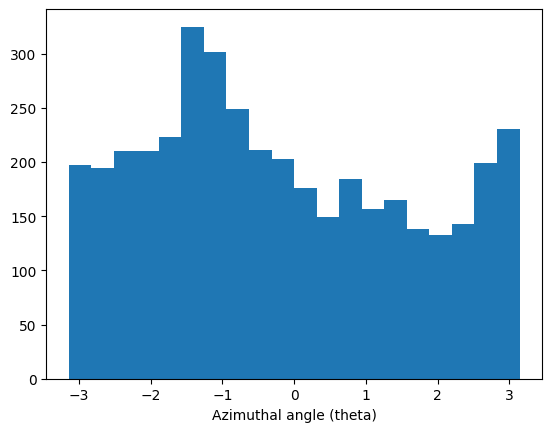

In [4]:
# calculate center of cluster in order to transform into spherical coords
center = (stats(mode1)[0], stats(mode2)[0], stats(mode3)[0])


# calculate divergence statistics of original frames in order to compare with the artificially generated ones
max_div, min_div, reference_divergence = AE.verification(u_all)


# spherical coordinates transformation
d = np.sqrt((mode1 - center[0])**2 + (mode2 - center[1])**2 + (mode3 - center[2])**2)[0, 0, :]
phi = np.arctan2(np.sqrt(mode1 ** 2 + mode2 ** 2), mode3)[0, 0, :]
theta = np.arctan2(mode1, mode2)[0, 0, :]

# calculate statistics for the distance, needed because gaussian function will be used to approximate its distribution
mu = np.mean(d)
sigma = np.std(d)

plt.hist(d, 20)
plt.xlabel('d')
plt.show()
plt.hist(phi, 20)
plt.xlabel('Angle (phi)')
plt.show()
plt.hist(theta, 20)
plt.xlabel('Azimuthal angle (theta)')
plt.show()

From the plots, we can assume that the distances can be modelled by a Gaussian distribution, and both the polar and the azimuthal angles can be modelled by a uniform distribution. Using these distributions, we now can randomly generate values for the distance, and the polar and azimuthal angles. This can then be translated to a set of three coordinates in the parameter space of the first three modes. In order to complete the generated latent space, all that is now needed is a value for the fourth mode. We can plot the histogram of the values of this mode, and from there select an appropriate probability distribution function to model it.

(array([ 52., 146., 216., 259., 279., 260., 248., 220., 246., 323., 341.,
        261., 219., 205., 180., 172., 156., 142.,  59.,  16.]),
 array([-0.47526938, -0.42835668, -0.38144398, -0.33453128, -0.28761858,
        -0.24070589, -0.19379319, -0.14688049, -0.0999678 , -0.0530551 ,
        -0.00614241,  0.04077029,  0.08768298,  0.13459568,  0.18150838,
         0.22842108,  0.27533376,  0.32224646,  0.36915916,  0.41607186,
         0.46298456]),
 <BarContainer object of 20 artists>)

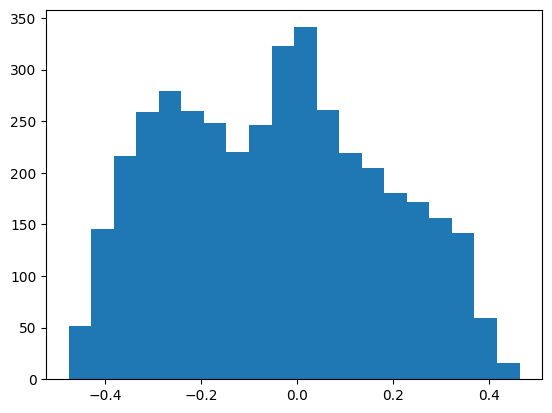

In [6]:
plt.hist(mode4[0,0,:], 20)

From there, we can take a subset of the histogram, and use a uniform distribution to model the fourth mode. Since we now have probability distribution functions to model all the parameters needed to generate a latent space, we can define the function create_art(). This function will generate a latent space, and will decode this latent space, generating a frame of flow data. Furthermore, the total divergence of this frame is summed up, and from this we determine if the flow is so-called 'physical' or not. Here, our definition of physical means that it is within a range of 90% difference wtih respect to the value of the average divergence of all 4000 given frames of flow data.

In [7]:

def create_art():
    """
    Function that uses distribution functions to generate artificial latent spaces and related flow fields
    :return: artificial latent space, divergence array of artificial flow, boolean checking physical conditions and
             artificial flow field
    """

    # generate values for d, phi, theta with respectively a gaussian, uniform and uniform distribution
    d_art = random.gauss(mu, sigma)
    phi_art = random.uniform(0, np.pi)
    theta_art = random.uniform(0, 2 * np.pi)

    # use artificially generated parameters to determine latent space modes' magnitudes
    m3_art = d_art * np.cos(phi_art)
    m2_art = d_art * np.sin(phi_art) * np.cos(theta_art)
    m1_art = d_art * np.sin(phi_art) * np.sin(theta_art)

    # creation of artificial latent space, mode 4 is found using uniform distribution
    latent_art = [m1_art, m2_art, m3_art, random.uniform(-0.2, 0.2)]

    # generate artifical flow field
    frame_art = generate(latent_art)

    # Isolate velocity components
    u_vel = frame_art[:, :, 0]
    v_vel = frame_art[:, :, 1]
    # Partial derivatives (du/dx, dv/dy) step size set to 0.262 based on grid size
    u_vel_grad = np.gradient(u_vel, axis=0)
    v_vel_grad = np.gradient(v_vel, axis=1)
    divergence = np.add(u_vel_grad, v_vel_grad)

    # check if flow is physical based on a range determined by looking at original time series average divergence
    physicality = reference_divergence * 0.1 < np.sum(divergence) < reference_divergence * 1.9
    return latent_art, divergence, physicality, frame_art



We can then plot the resulting flow frame of one such artificially generated latent space:

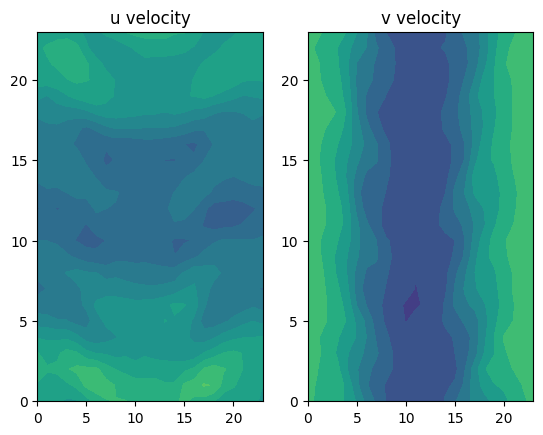

In [8]:
latent_art, div, phys, artificial_frame = create_art()

AE.u_v_plot(artificial_frame)

As we can see, this frame already looks similar to the ones provided at the start of the project. As the last step, we can now generate a multitude of artificially generated frames, and compare their statistics regarding divergence with the given frames of flow data. To that end, we will create the dictionary called latents, in which we will store for each randomly generated latent space the values of this latent space, its divergence, a boolean telling us whether it fits our definition of physical, and the arrays of the decoded frame.

In [9]:
# Generate 1000 artificial flows in order to compare with original time series
latents: dict[str, tuple[list, list, bool, list]] = {}
count = 0
total = 1000
divergences = []
for i in tqdm(np.arange(0, total + 1), colour='green'):
    latents[f'{i}'] = create_art()
    divergences.append(np.sum(latents[f'{i}'][1]))
    if latents[f'{i}'][2]:
        count += 1

divergences = np.array(divergences)

100%|██████████| 1001/1001 [00:46<00:00, 21.68it/s]


Finally, we can compare the statistics, where count denotes the number of frames :

In [10]:
print(f'Original flow data has maximum divergence: {max_div}, minimum divergence: {min_div}, average divergence: {reference_divergence}')
print(f'Range of physicality, as defined by the team: {reference_divergence * 0.1} < divergence < {reference_divergence * 1.9}')

# print statistics of the artificially generated flow field series
print(f'Artificial flow data has maximum divergence: {np.max(divergences)}, minimum divergence: {np.min(divergences)}, average divergence: {np.sum(np.abs(divergences)) / len(divergences)}')
print(f'Number of artificial flow data which is physical: {count}')

Original flow data has maximum divergence: 0.47206987724253047, minimum divergence: -2.1449538805165127, average divergence: -0.34671896172862365
Range of physicality, as defined by the team: -0.034671896172862364 < divergence < -0.6587660272843849
Artificial flow data has maximum divergence: 0.4826211929321289, minimum divergence: -2.1026620864868164, average divergence: 0.710125201946491
Number of artificial flow data which is physical: 0


This concludes this notebook, in which has been demonstrated how the team arrived at a working model to quickly generate artificial flow data. Some analysis has been done regarding the physicality of these generated frames, which seems acceptable. The team reccommends future investigation into the manner in which to define physicality, for so far this is possible.